In [6]:
import networkx as nx
import numpy as np
import torch
from model import CaT
from utils.inference import CausalInference
import matplotlib.pyplot as plt
from CaT.datasets import reorder_dag, get_full_ordering
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from sklearn.linear_model import LinearRegression

seed = 1
standardize = 0
sample_size = 100000
batch_size = 300
max_iters = 5000
eval_interval = 1000
eval_iters = 100
validation_fraction = 0.1
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 2e-4
ff_n_embed = 4
num_heads = 3
n_layers = 1
head_size = 4
embed_dim = 5
d = 1


def generate_data(N, d=1):
    DAGnx = nx.DiGraph()

    
    Uc = np.random.randn(N,d)
    C =  Uc

        
    Ux = np.random.randn(N,d)
    X =  1 * C + Ux
    
    Uy = np.random.randn(N,d)
    Y = 0.8 * X  + 1.5 * C + Uy

    Y0 = 0.8 * 0 + 1.5 * C + Uy
    Y1 = 0.8 * 1  + 1.5 * C +  Uy

    all_data_dict = {'X': X,  'C': C, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont',  'C': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('C', 'X'), ('C', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)
    ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

    return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1


def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

def input_output_sensitivity_matrix(input, model, epsilon=100.0, full=True):
    model.eval()
    input = input.detach().clone() 
    
    if full:
        original_output, _, _ = model(X=input, targets=input)
    else:
        original_output = model(X=input)
    
    sensitivity_matrix = torch.zeros((input.size(1), original_output.size(1)))

    for i in range(input.size(1)): 
        perturbed_input = input.clone()
        perturbed_input[0, i] += epsilon  
        
        if full:
            perturbed_output, _, _ = model(X=perturbed_input, targets=perturbed_input)
        else:
            perturbed_output = model(X=perturbed_input)
            
        output_difference = perturbed_output - original_output

        sensitivity_matrix[i, :] =  torch.abs(output_difference.view(-1))
    
    return sensitivity_matrix

## Confounding Example

In [7]:

all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=100000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample

print('ATE:', ATE)

ATE: [0.8]


In [8]:
X = all_data[:, :2, 0] 
y = all_data[:, 2:3, 0]
reg = LinearRegression(fit_intercept=True).fit(X, y)
print('Intercept:', reg.intercept_)
print('Coefficients:', reg.coef_[0])

Intercept: [-0.00200594]
Coefficients: [1.49799063 0.79865823]


The coefficients from the linear regression are highly biased as a result of the confounder... Now let's try with CaT!

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


step 0 of 5000: train_loss 14.1705, val loss 14.1080
step 1000 of 5000: train_loss 2.5668, val loss 2.6084
step 2000 of 5000: train_loss 2.0550, val loss 2.0339
step 3000 of 5000: train_loss 1.9878, val loss 1.9899
step 4000 of 5000: train_loss 1.9964, val loss 1.9898


/tmp/ipykernel_10633/1694027014.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


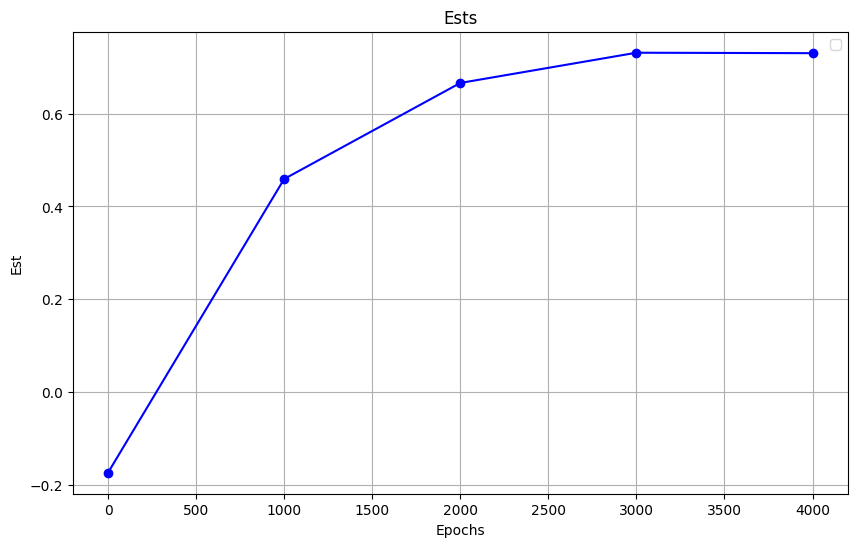

/tmp/ipykernel_10633/1694027014.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


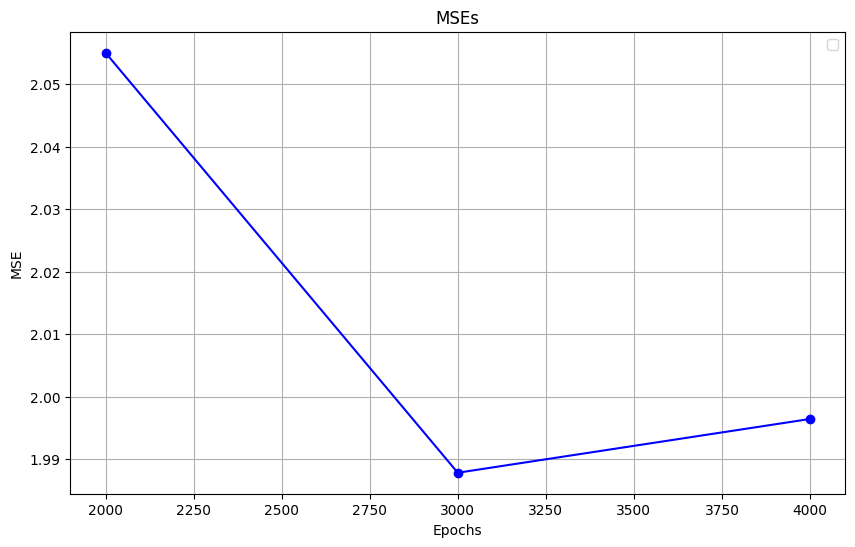

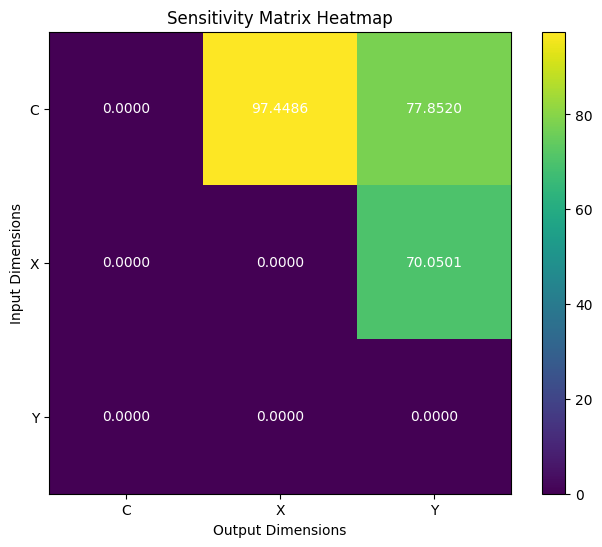

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


ATE: [0.8] est ATE: 0.7472471358386927
step 0 of 5000: train_loss 27.3156, val loss 27.3195
step 1000 of 5000: train_loss 2.1700, val loss 2.2217
step 2000 of 5000: train_loss 2.0062, val loss 2.0464
step 3000 of 5000: train_loss 1.9954, val loss 2.0173
step 4000 of 5000: train_loss 2.0166, val loss 2.0258


/tmp/ipykernel_10633/1694027014.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


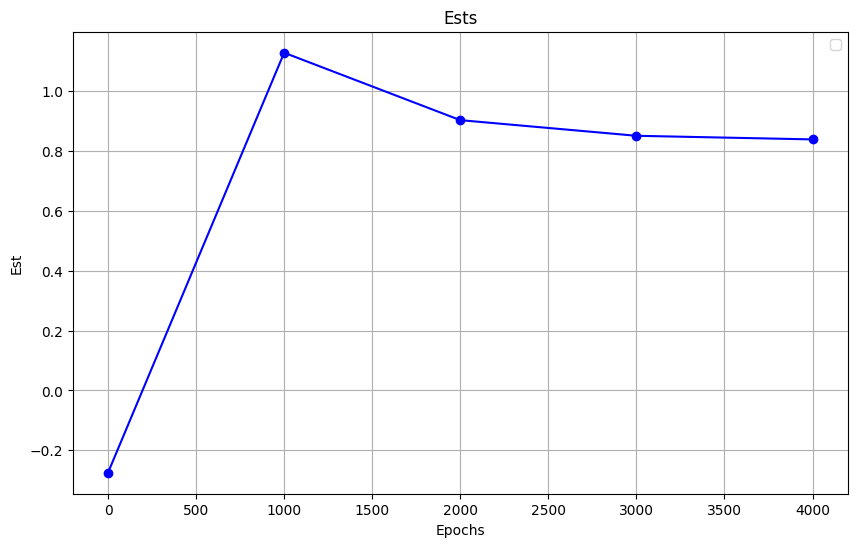

/tmp/ipykernel_10633/1694027014.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


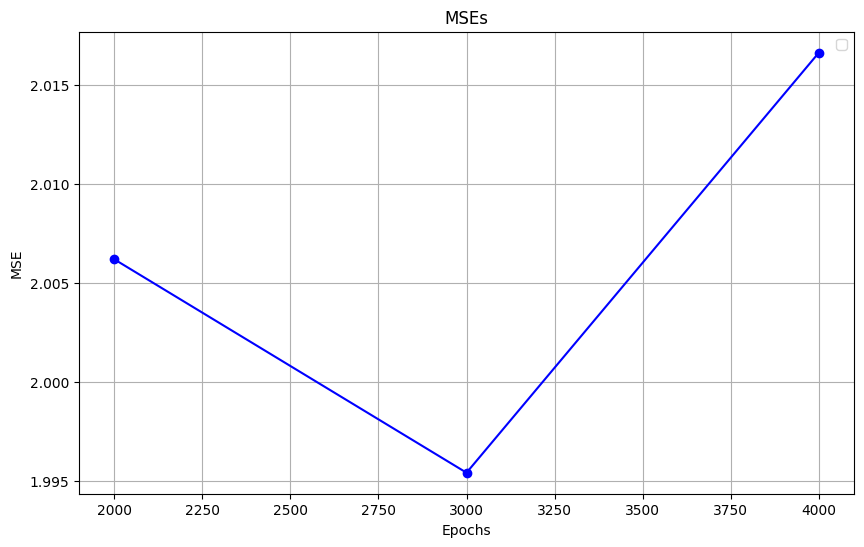

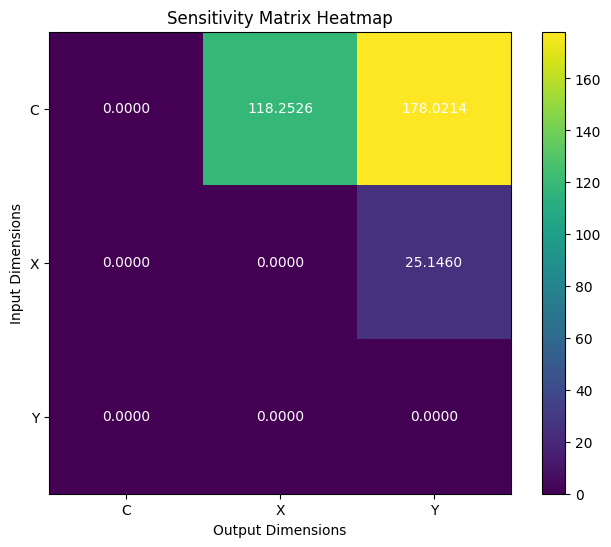

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


ATE: [0.8] est ATE: 0.8479503929207288
step 0 of 5000: train_loss 9.5847, val loss 9.3684
step 1000 of 5000: train_loss 2.0768, val loss 2.0526
step 2000 of 5000: train_loss 1.9828, val loss 1.9843
step 3000 of 5000: train_loss 1.9972, val loss 1.9668
step 4000 of 5000: train_loss 1.9843, val loss 1.9902


/tmp/ipykernel_10633/1694027014.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


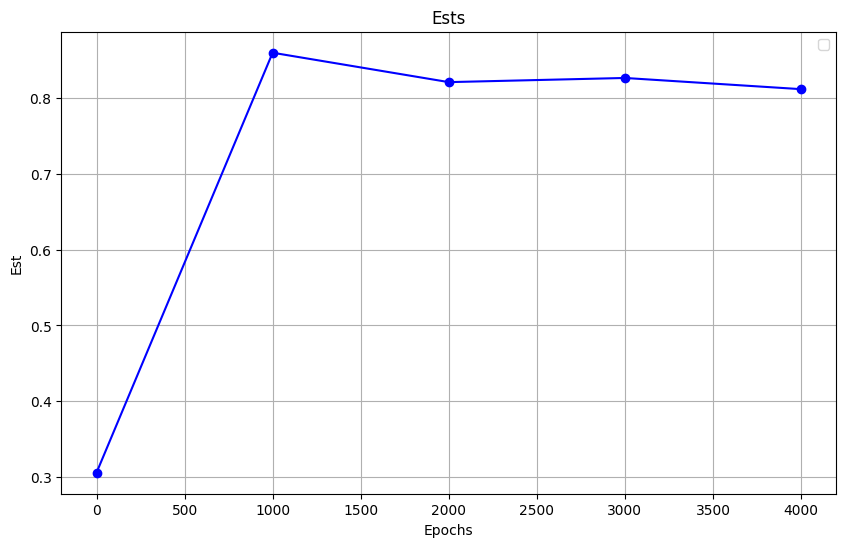

/tmp/ipykernel_10633/1694027014.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


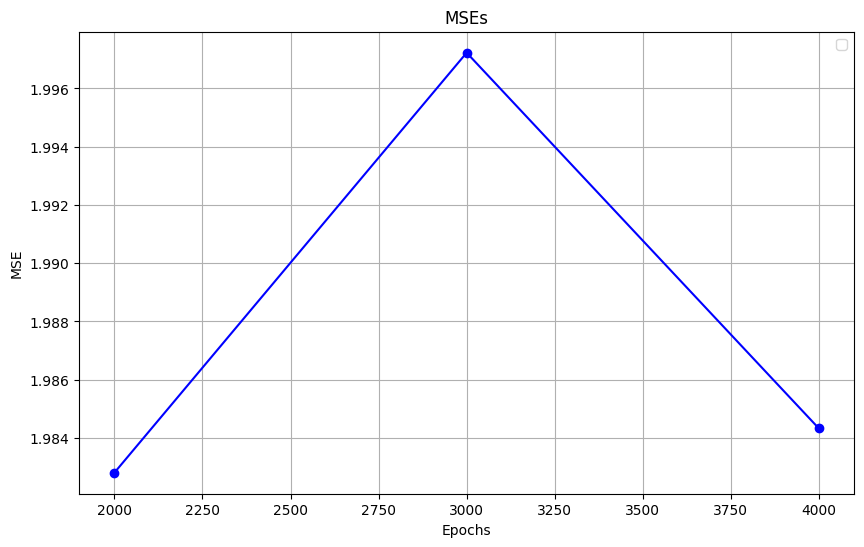

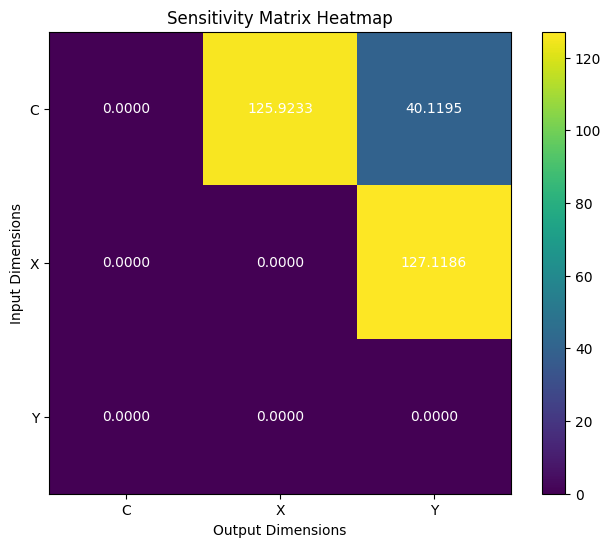

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


ATE: [0.8] est ATE: 0.817550414448902
step 0 of 5000: train_loss 13.8494, val loss 14.1125
step 1000 of 5000: train_loss 2.9483, val loss 3.0509
step 2000 of 5000: train_loss 1.9997, val loss 1.9859
step 3000 of 5000: train_loss 2.0168, val loss 2.0027
step 4000 of 5000: train_loss 1.9996, val loss 2.0010


/tmp/ipykernel_10633/1694027014.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


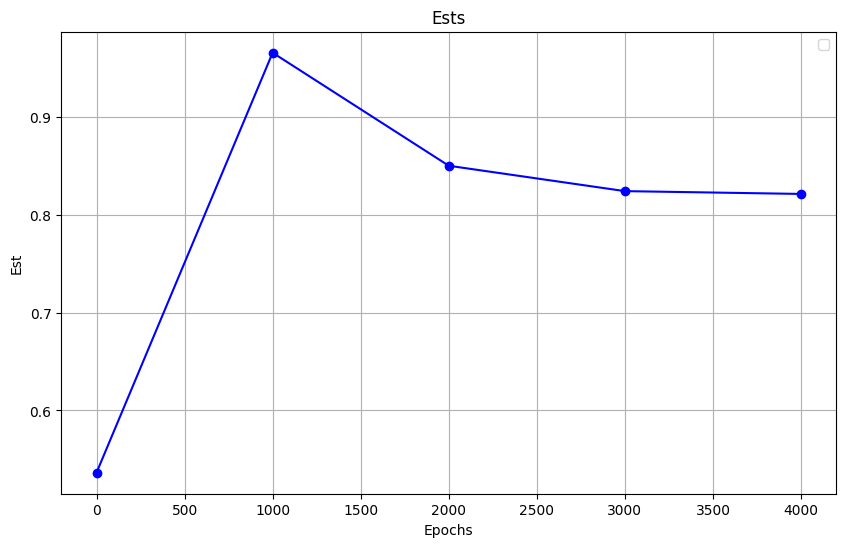

/tmp/ipykernel_10633/1694027014.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


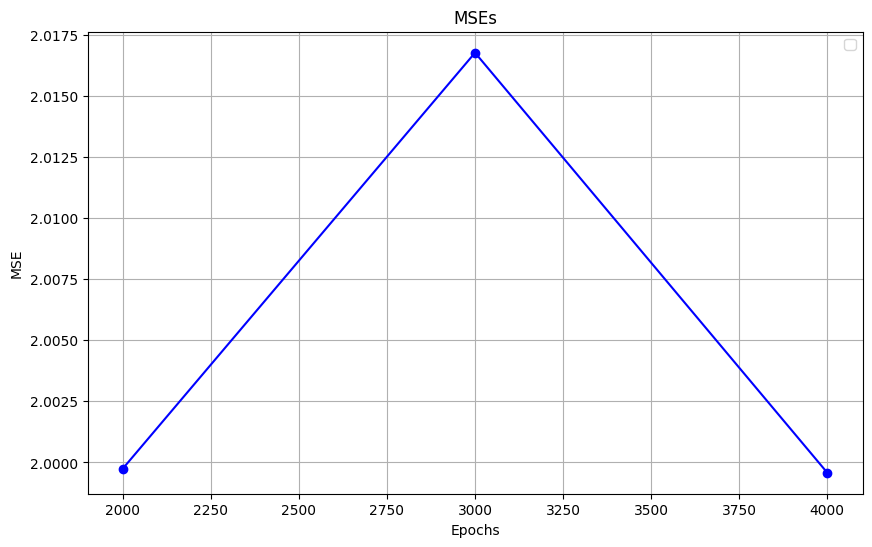

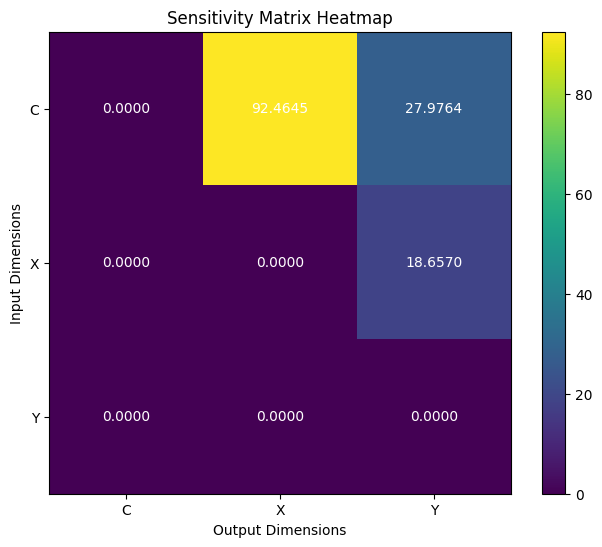

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


ATE: [0.8] est ATE: 0.8190371262023598
step 0 of 5000: train_loss 6.6375, val loss 6.5300
step 1000 of 5000: train_loss 2.2041, val loss 2.1953
step 2000 of 5000: train_loss 2.0029, val loss 2.0034
step 3000 of 5000: train_loss 2.0049, val loss 1.9874
step 4000 of 5000: train_loss 1.9805, val loss 1.9931


/tmp/ipykernel_10633/1694027014.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


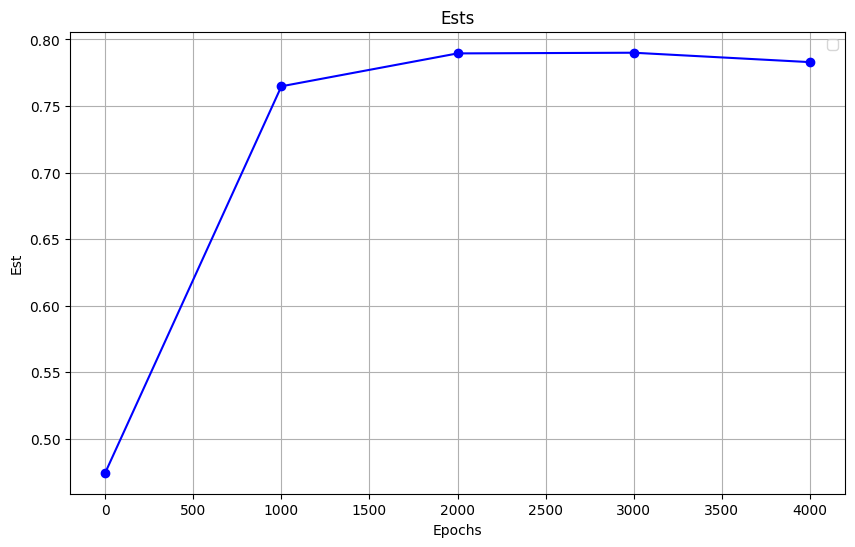

/tmp/ipykernel_10633/1694027014.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


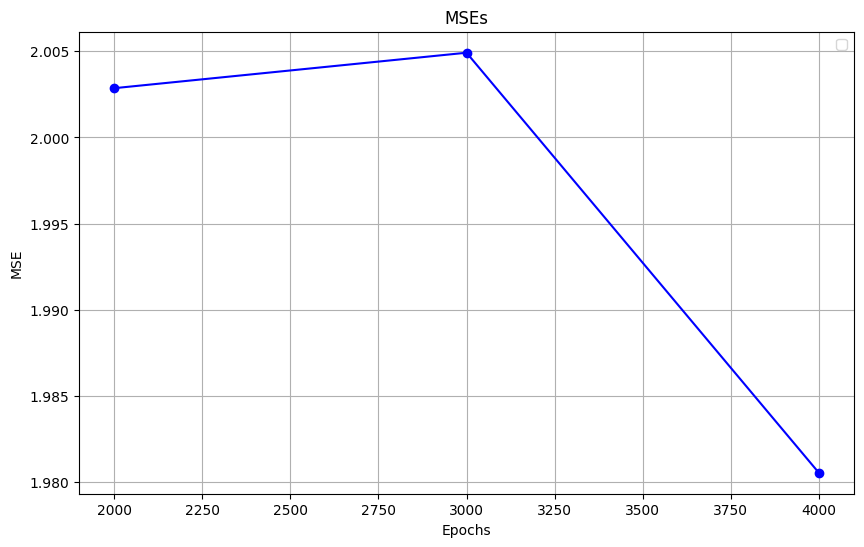

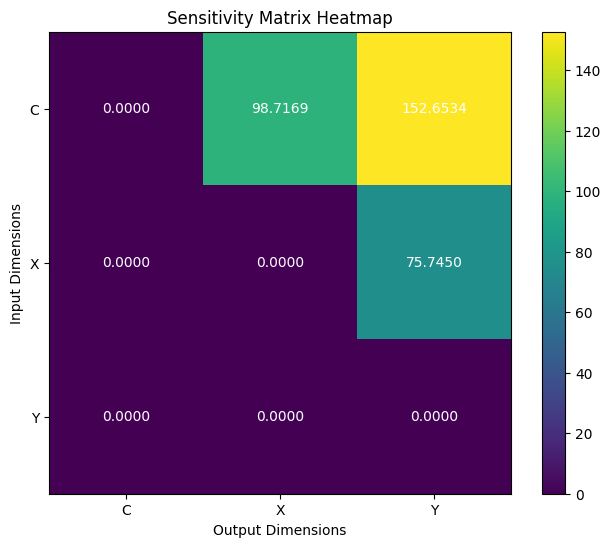

ATE: [0.8] est ATE: 0.7870076184293627
[0.7472471358386927, 0.8479503929207288, 0.817550414448902, 0.8190371262023598, 0.7870076184293627]


/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


In [9]:

estimates = []

for i in range(5):
    
    all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
    
    indices = np.arange(0, len(all_data))
    np.random.shuffle(indices)
    
    val_inds = indices[:int(validation_fraction*len(indices))]
    train_inds = indices[int(validation_fraction*len(indices)):]
    
    train_data = all_data[train_inds]
    val_data = all_data[val_inds]
    
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    input_dim = all_data.shape[2]
    
    model = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx,
                    causal_ordering=causal_ordering,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types, activation_function='Swish'
                    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    def lr_lambda(epoch):
        if epoch < warmup_iters:
            return float(epoch) / float(max(1, warmup_iters))
        return 1.0
    
    warmup_iters = max_iters//5  # Number of iterations for warmup
    scheduler_warmup = LambdaLR(optimizer, lr_lambda=lr_lambda)
    scheduler_cyclic = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_iters)

    
    all_var_losses = {}
    inter_model_ests = []
    sub_epoch = []
    mses = [] 
    for iter_ in range(0, max_iters):
        # train and update the model
        model.train()
    
        xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod)
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if iter_ < warmup_iters:
            scheduler_warmup.step()
        else:
            scheduler_cyclic.step()
    
    
        if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
            for key in loss_dict.keys():
                if key not in all_var_losses.keys():
                    all_var_losses[key] = []
                all_var_losses[key].append(loss_dict[key])
    
            model.eval()
            eval_loss = {}
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
    
                    xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                                   batch_size=batch_size)
                    xb_mod = torch.clone(xb.detach())
                    X, loss, loss_dict = model(X=xb, targets=xb_mod)
                    losses[k] = loss.item()
                eval_loss[split] = losses.mean()
            mses.append(eval_loss['train'])
                
            intervention_nodes_vals_0 = {'X':  0}
            intervention_nodes_vals_1 = {'X':  1}
            ci = CausalInference(dag=DAGnx)
            D0 = ci.forward(data=all_data, model=model, intervention_nodes_vals=intervention_nodes_vals_0)
            D1 = ci.forward(data=all_data, model=model, intervention_nodes_vals=intervention_nodes_vals_1)
            
            effect_var = 'Y'
            effect_index = var_names.index(effect_var)

            
            est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
            inter_model_ests.append(est_ATE)
            sub_epoch.append(iter_)
            model.train()
            print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(sub_epoch, inter_model_ests, marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Est')
    plt.title('Ests')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(sub_epoch[2:], mses[2:], marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('MSEs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    sensitivity_matrix = input_output_sensitivity_matrix(xb[0:1], model, full=True).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(sensitivity_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    
    for i in range(sensitivity_matrix.shape[0]):
        for j in range(sensitivity_matrix.shape[1]):
            plt.text(j, i, f'{sensitivity_matrix[i, j]:.4f}', ha='center', va='center', color='white')
    
    plt.xlabel('Output Dimensions')
    plt.ylabel('Input Dimensions')
    plt.title('Sensitivity Matrix Heatmap')
    plt.xticks(ticks=np.arange(len(var_names)), labels=var_names)
    plt.yticks(ticks=np.arange(len(var_names)), labels=var_names)
    # Display the plot
    plt.show()
    
    
    model.eval()
    intervention_nodes_vals_0 = {'X':  0}
    intervention_nodes_vals_1 = {'X':  1}
    ci = CausalInference(dag=DAGnx)
    D0 = ci.forward(data=all_data, model=model, intervention_nodes_vals=intervention_nodes_vals_0)
    D1 = ci.forward(data=all_data, model=model, intervention_nodes_vals=intervention_nodes_vals_1)
    
    
    effect_var = 'Y'
    effect_index = effect_index = var_names.index(effect_var)
    
    est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
    print('ATE:', ATE, 'est ATE:', est_ATE)
    estimates.append(est_ATE)
    
print(estimates)
